In [1]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import keras.backend as K

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Load in the Dataset

In [2]:
X_train = np.load("/floyd/input/skin_cancer_192_256/256_192_train.npy")

In [3]:
y_train = np.load("/floyd/input/skin_cancer_192_256/train_labels.npy")

In [4]:
X_val = np.load("/floyd/input/skin_cancer_192_256/256_192_val.npy")

In [5]:
y_val = np.load("/floyd/input/skin_cancer_192_256/val_labels.npy")

In [6]:
X_train.shape, X_val.shape

((8111, 192, 256, 3), (902, 192, 256, 3))

In [7]:
y_train.shape, y_val.shape

((8111,), (902,))

In [8]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [9]:
y_train.shape, y_val.shape

((8111, 7), (902, 7))

## Load Pretrained Model

In [10]:
pre_trained_model = InceptionResNetV2(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

219062272/219055592 [==============================] - 15s 0us/step


In [11]:
for layer in pre_trained_model.layers:
    print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

print(len(pre_trained_model.layers))

input_1
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
conv2d_3
batch_normalization_3
activation_3
max_pooling2d_1
conv2d_4
batch_normalization_4
activation_4
conv2d_5
batch_normalization_5
activation_5
max_pooling2d_2
conv2d_9
batch_normalization_9
activation_9
conv2d_7
conv2d_10
batch_normalization_7
batch_normalization_10
activation_7
activation_10
average_pooling2d_1
conv2d_6
conv2d_8
conv2d_11
conv2d_12
batch_normalization_6
batch_normalization_8
batch_normalization_11
batch_normalization_12
activation_6
activation_8
activation_11
activation_12
mixed_5b
conv2d_16
batch_normalization_16
activation_16
conv2d_14
conv2d_17
batch_normalization_14
batch_normalization_17
activation_14
activation_17
conv2d_13
conv2d_15
conv2d_18
batch_normalization_13
batch_normalization_15
batch_normalization_18
activation_13
activation_15
activation_18
block35_1_mixed
block35_1_conv
block35_1
block35_1_ac
conv2d_22
batch_normalization_22
activation_22
conv2d_20
c

In [12]:
last_layer = pre_trained_model.get_layer('conv_7b_ac')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 4, 6, 1536)


## Define the Model

In [13]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.7
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 95, 127, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 95, 127, 32)  96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 95, 127, 32)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## Training

### Feature Extraction

In [16]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [17]:
batch_size = 64
epochs = 3
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))

Epoch 1/3
126/126 [==============================] - 284s 2s/step - loss: 1.4064 - acc: 0.6044 - val_loss: 1.0709 - val_acc: 0.6652
Epoch 2/3
126/126 [==============================] - 246s 2s/step - loss: 1.0660 - acc: 0.6624 - val_loss: 0.9677 - val_acc: 0.6629
Epoch 3/3
126/126 [==============================] - 244s 2s/step - loss: 1.0015 - acc: 0.6736 - val_loss: 0.9083 - val_acc: 0.7062


### Fine Tuning

In [18]:
pre_trained_model.layers[617].name

'mixed_7a'

In [19]:
for layer in pre_trained_model.layers[618:]:
    layer.trainable = True

In [20]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 95, 127, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 95, 127, 32)  96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 95, 127, 32)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [23]:
batch_size = 64
epochs = 25
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

Epoch 1/25
126/126 [==============================] - 295s 2s/step - loss: 0.8628 - acc: 0.7063 - val_loss: 0.7964 - val_acc: 0.7299
Epoch 2/25
126/126 [==============================] - 255s 2s/step - loss: 0.6972 - acc: 0.7484 - val_loss: 0.6494 - val_acc: 0.7455
Epoch 3/25
126/126 [==============================] - 254s 2s/step - loss: 0.6242 - acc: 0.7717 - val_loss: 0.6173 - val_acc: 0.7796
Epoch 4/25
126/126 [==============================] - 255s 2s/step - loss: 0.5684 - acc: 0.7920 - val_loss: 0.6669 - val_acc: 0.7612
Epoch 5/25
126/126 [==============================] - 254s 2s/step - loss: 0.5231 - acc: 0.8074 - val_loss: 0.6269 - val_acc: 0.7796
Epoch 6/25
126/126 [==============================] - 254s 2s/step - loss: 0.4803 - acc: 0.8250 - val_loss: 0.5392 - val_acc: 0.7746

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 7/25
126/126 [==============================] - 254s 2s/step - loss: 0.3935 - acc: 0.8549 - val_loss: 0.5408 - val_

In [24]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=1)

In [25]:
 model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                     epochs = 5, validation_data = val_datagen.flow(X_val, y_val),
                     verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                     validation_steps=(X_val.shape[0] // batch_size),
                     callbacks=[learning_rate_reduction])

Epoch 1/5
126/126 [==============================] - 255s 2s/step - loss: 0.1731 - acc: 0.9371 - val_loss: 0.5915 - val_acc: 0.8326
Epoch 2/5
126/126 [==============================] - 254s 2s/step - loss: 0.1684 - acc: 0.9415 - val_loss: 0.6937 - val_acc: 0.8058
Epoch 3/5
126/126 [==============================] - 254s 2s/step - loss: 0.1696 - acc: 0.9383 - val_loss: 0.6034 - val_acc: 0.8294

Epoch 00003: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
Epoch 4/5
126/126 [==============================] - 254s 2s/step - loss: 0.1637 - acc: 0.9400 - val_loss: 0.7378 - val_acc: 0.7924
Epoch 5/5
126/126 [==============================] - 254s 2s/step - loss: 0.1698 - acc: 0.9399 - val_loss: 0.6576 - val_acc: 0.7844

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.


In [26]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

902/902 [==============================] - 12s 13ms/step
Validation: accuracy = 0.808204  ;  loss_v = 0.669130


## Testing

In [27]:
X_test = np.load("/floyd/input/skin_cancer_192_256/256_192_test.npy")

In [28]:
y_test = np.load("/floyd/input/skin_cancer_192_256/test_labels.npy")
y_test = to_categorical(y_test)

In [29]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

1002/1002 [==============================] - 13s 13ms/step
Test: accuracy = 0.825349  ;  loss = 0.640084


In [30]:
model.save("InceptionResNet.h5")

Text(0.5,1,'Training and validation loss')

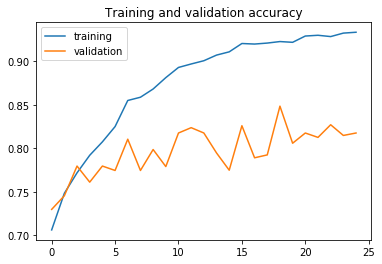

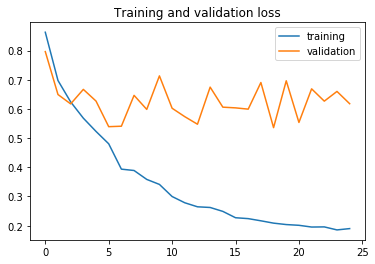

In [31]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')